## Question 1

**Minimum Cut**
_________________
$MinCut_1 = 20 +  10 + 10 = 40$<br/>
$MinCut_2 = 10 + 10 + 10 + 20 = 50$

**Normalized Cut**
____________
$NCut_1 = 40\times(\frac{1}{3+2} + \frac{1}{3+2+3+4+2+3+2}) = 10.104$<br>
$NCut_2 = 50\times(\frac{1}{2+3+4+3} + \frac{1}{2+2+3+2})=9.72$
_____________________
Minimum cut will favor C1 since while Normalized cut will favor C2, this is because min-cut favors cuts with lower wieght while normalized cut adds to this objective that it favors the more balanced partition, and since C2 is more balanced than C1, it favors C2.


## Question 2

In [1]:
import numpy as np
import scipy
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances, manhattan_distances
from scipy.special import comb
from collections import deque

In [2]:
X1 = np.array([
    (5, 8), # a
    (10, 8),# b
    (11, 8),# c
    (6, 7), # d
    (10, 7),# e
    (12, 7),# f
    (13, 7),# g
    (5, 6), # h
    (10, 6),# i
    (13, 6),# j
    (14, 6),# n
    (6, 5), # k
    (11, 5),# m
    (15, 5),# o
    (2, 4), # p
    (3, 4), # q
    (5, 4), # r
    (6, 4), # s
    (7, 4), # t
    (9, 4), # l
    (15, 4),# u
    (3, 3), # v
    (7, 3), # w
    (8, 2)  # x
])

In [3]:
def rel_diff(x, y):
    return abs(x-y)/max(x,y)

def k_means(points, k=3, threshold=0.001, max_iters=100, dist_func='euclidean'):
    '''
        returns a numpy array with the centroid of each point at its index in the
        points array, and an array containing the centroids
    '''
    
    dist = {'euclidean':euclidean_distances, 'manhattan':manhattan_distances}[dist_func]
    # assume points are gaussian and pick k random points from the destribution as the centroids
    centroids = np.var(points, axis=0) * np.random.randn(k, points.shape[1]) + np.mean(points, axis=0)
    prev_loss = 1e9
    for i in range(max_iters):
        dists_to_centroids = dist(X=points, Y=centroids)
        assignment = np.argmin(dists_to_centroids, axis=1)
        loss = np.sum(np.linalg.norm(centroids[assignment] - points, axis=1)**2)
        if rel_diff(loss, prev_loss) <= threshold:
            break
        prev_loss = loss
        # update the centroids
        for cent_idx in range(k):
            cent_points = points[np.where(assignment==cent_idx)]
            if cent_points.shape[0] > 0: # to protect against when no points belong to the centroid
                centroids[cent_idx] = np.mean(cent_points, axis=0)
        
    return assignment, centroids, loss

def k_means_rep(points, k=3, threshold=0.001, max_iters=100, dist_func='euclidean', reps=1, ):
    min_loss = 1e9
    best_centroids, best_assignment = None, None
    for rep in range(reps):
        assignment, centroids, loss = k_means(points=points, k=k, threshold=threshold, max_iters=max_iters, dist_func=dist_func)
        if loss < min_loss:
            min_loss, best_centroids, best_assignment = loss, centroids, assignment
    return best_assignment, best_centroids, min_loss


In [119]:
def is_connected(affinity):
    num_vertices = affinity.shape[0]
    visited = np.zeros(num_vertices)
    def _dfs(u):
        if visited[u] == 1:
            return
        visited[u] = 1
        for v in range(num_vertices):
            if affinity[u,v] > 1e-20:
                _dfs(v)
        return np.sum(visited) == num_vertices
    
    return _dfs(0)


def spectral_clustering(affinity, k=3, n_clusters=3, reps=5):
    # compute the degree matrix and its inverse
    degree_diag = np.sum(affinity, axis=1)
    degree_mat = np.diag(degree_diag)
    inv_degree_mat = np.diag(1/degree_diag)
    
    # compute the Laplacian and asymetric Laplacian
    Laplacian = degree_mat - affinity
    Laplacian_a = inv_degree_mat.dot(Laplacian)
    
    # first k eigen vectors of the asymetric Laplacian
    e_vals,e_vecs = np.linalg.eig(Laplacian_a)
    sorted_idx = np.argsort(e_vals)
    e_vals = e_vals[sorted_idx]
    e_vecs = e_vecs[sorted_idx]
    all_vecs=e_vecs
    e_vecs = e_vecs[:,0:k]
    # normalize the eigen vectors
    norm_vecs = e_vecs.real / np.sqrt(np.linalg.norm(e_vecs.real))
    cluster_indicator = KMeans(n_clusters=k).fit_predict(norm_vecs)

    return cluster_indicator, norm_vecs
# all_vecs,e_vals


def cluster_plotter(vecs, cluster_indicator):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = ['r','b','y','g','k','m']
    def _plot(cluster_num):
        cluster = vecs[cluster_indicator == cluster_num]
        ax.scatter(cluster[:,0], cluster[:,1], cluster[:,2], c=colors[cluster_num], label=f'cluster {cluster_num}')
    return _plot
        


### RBF Kernel

gamma = 0.01 produced a connected graph


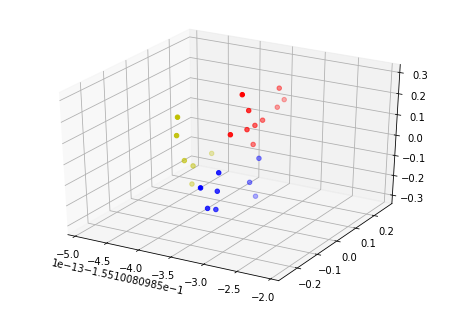

gamma = 0.1 produced a connected graph


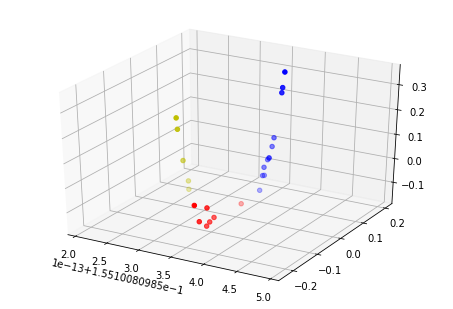

gamma = 1 produced a connected graph


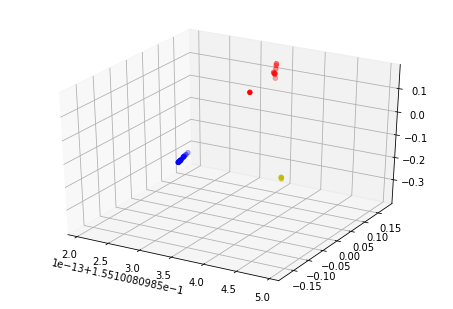

gamma = 10 produced a disconnected graph


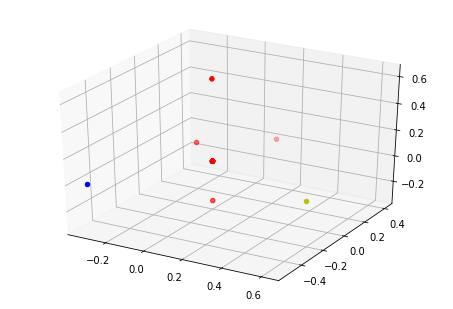

In [5]:
N_CLUSTERS = 3
for gamma in [0.01, 0.1, 1, 10]:
    affinity = rbf_kernel(X1, gamma=gamma)
    
    if is_connected(affinity):
        print(f'gamma = {gamma} produced a connected graph')
    else:
        print(f'gamma = {gamma} produced a disconnected graph')

    cluster_indicator, norm_vecs = spectral_clustering(affinity,n_clusters=N_CLUSTERS)
    

    scatter = cluster_plotter(norm_vecs, cluster_indicator)
    for cluster_idx in range(N_CLUSTERS):
        scatter(cluster_idx)
    plt.show()


### 3-NN Graph

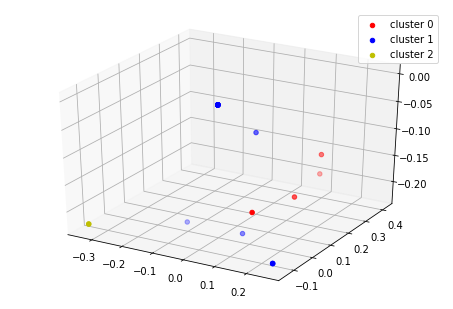

In [6]:

affinity = kneighbors_graph(X=X1, n_neighbors=3, n_jobs=-1, mode='connectivity',include_self=False).toarray()
cluster_indicator, norm_vecs = spectral_clustering(affinity,n_clusters=N_CLUSTERS, reps=10)

scatter = cluster_plotter(norm_vecs, cluster_indicator)
for cluster_idx in range(N_CLUSTERS):
    scatter(cluster_idx)

plt.legend()
plt.show()





### Clustreing Evaluation

In [7]:
X2 = np.array([[2,4], # p 0
               [3,3], # v 0
               [3,4], # q 0
               [5,4], # r 1
               [5,6], # h 1
               [5,8], # a 1
               [6,4], # s 1
               [6,5], # k 1
               [6,7], # d 1
               [7,3], # w 1
               [7,4], # t 1
               [8,2], # x 1
               [9,4], # l 1
               [10,6],# i 2
               [19,7],# e 2
               [10,8],# b 2
               [11,5],# m 2
               [11,8],# c 2
               [12,7],# f 2
               [13,6],# j 2
               [13,7],# g 2
               [14,6],# n 2
               [15,4],# u 2
               [15,5] # o 2
              ])

gt = np.asarray([0]*3 + [1]*10 + [2]*11)


### K-means

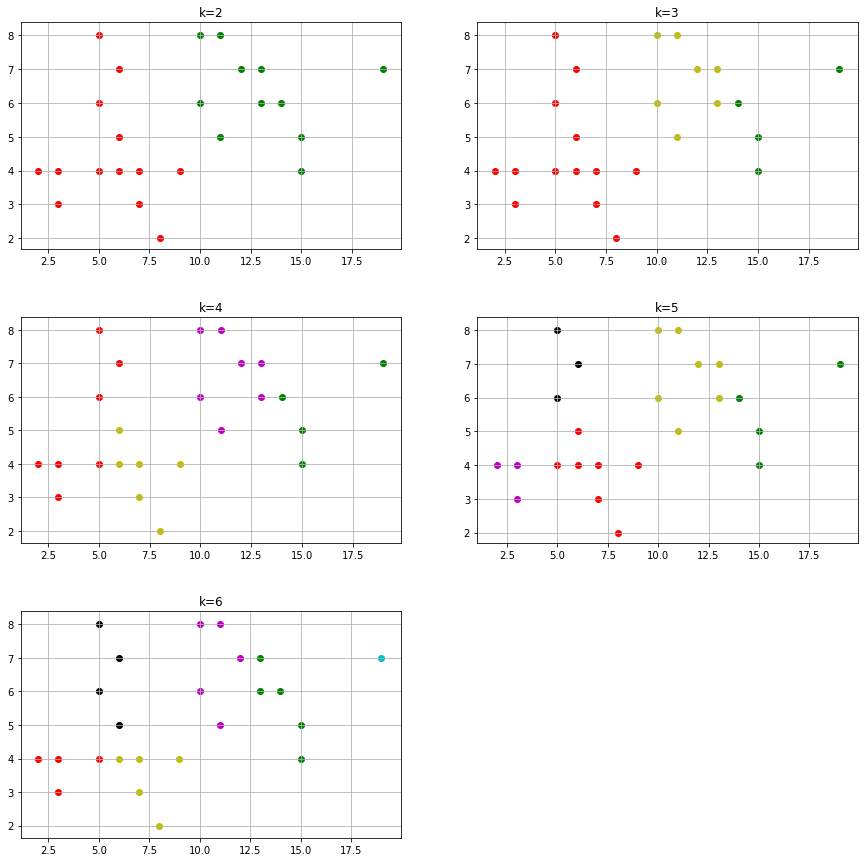

In [8]:
colors = ['r','g','y','m','k','c']
fig = plt.figure(figsize=(15,15))
k_means_cluster_indicators = {}
for k in range(2,7):
    cluster_indicator = KMeans(n_clusters=k).fit_predict(X2)
    k_means_cluster_indicators[k] = cluster_indicator
    ax = fig.add_subplot(3,2,k-2+1)
    for cluster in range(k):
        ax.scatter(X2[cluster_indicator==cluster,0], X2[cluster_indicator==cluster, 1], c=colors[cluster])
    ax.set_title(f'k={k}')
    ax.grid()
fig.subplots_adjust(hspace=0.3)
plt.show()

### k-ways normalized cut 

#### RBF

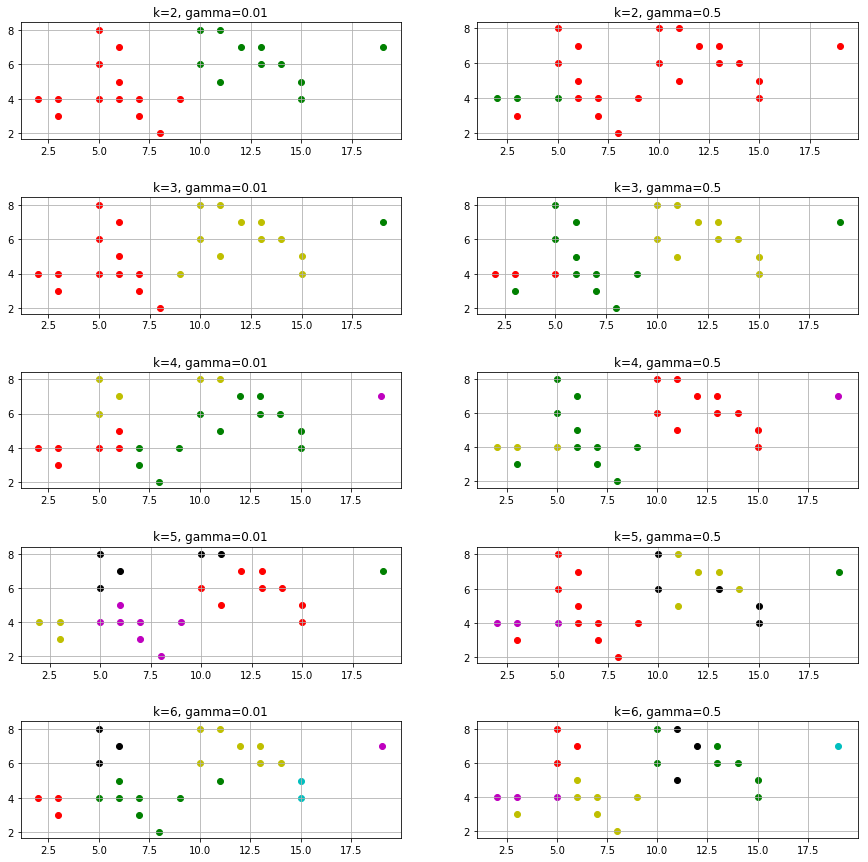

{2: {0.01: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32), 0.5: array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)}, 3: {0.01: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2], dtype=int32), 0.5: array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2], dtype=int32)}, 4: {0.01: array([0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1,
       1], dtype=int32), 0.5: array([2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)}, 5: {0.01: array([2, 2, 2, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 0, 1, 4, 0, 4, 0, 0, 0, 0, 0,
       0], dtype=int32), 0.5: array([3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 2, 2, 2, 4, 2, 2, 4,
       4], dtype=int32)}, 6: {0.01: array([0, 0, 0, 1, 4, 4, 1, 1, 4, 1, 1, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 5,
       5], dtype=int32), 0.5: array([3, 2

In [125]:
fig = plt.figure(figsize=(15,15))
plt_idx = 1
rbf_cluster_indicators = {}
for k in range(2,7):
    rbf_cluster_indicators[k] = {}
    for gamma in [0.01, 0.5]:
        affinity = rbf_kernel(X2, gamma=gamma)
        cluster_indicator, norm_vecs = spectral_clustering(affinity,n_clusters=k, k=k)
        rbf_cluster_indicators[k][gamma] = cluster_indicator
        ax = fig.add_subplot(5,2,plt_idx)
        for cluster in range(k):
            ax.scatter(X2[cluster_indicator==cluster,0], X2[cluster_indicator==cluster, 1], c=colors[cluster])
        ax.set_title(f'k={k}, gamma={gamma}')
        ax.grid()
        plt_idx+=1
fig.subplots_adjust(hspace=0.5)

plt.show()
print(rbf_cluster_indicators)

#### KNN Graph

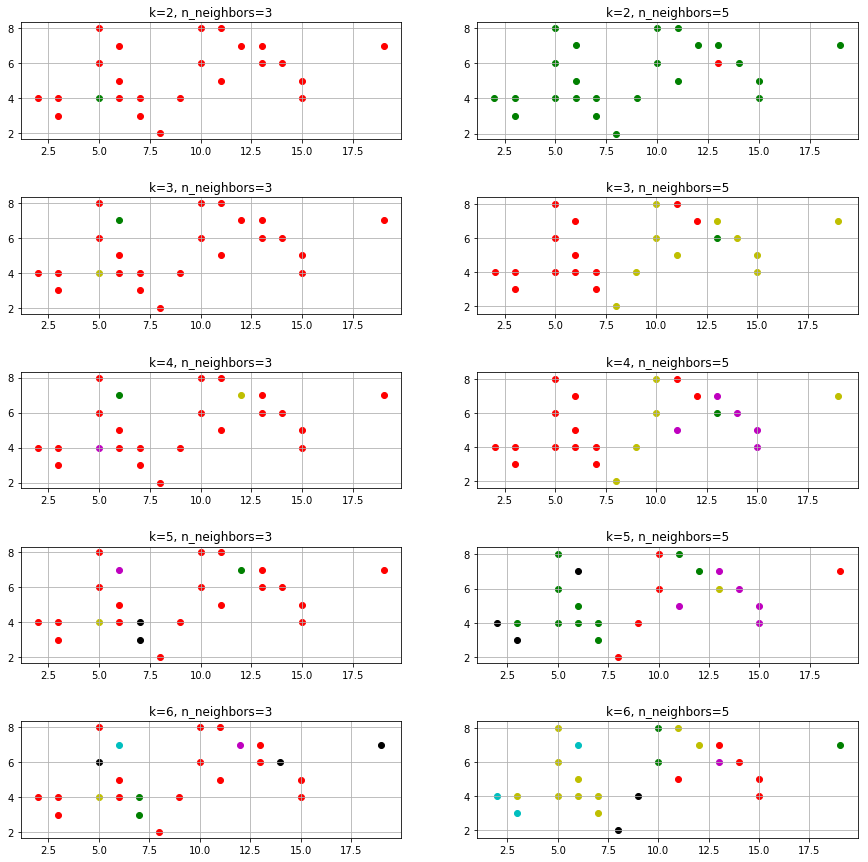

In [42]:
fig = plt.figure(figsize=(15,15))
plt_idx = 1
knn_cluster_indicator = {}
for k in range(2,7):
    knn_cluster_indicator[k] = {}
    for n_neighbors in [3, 5]:
        affinity = kneighbors_graph(X=X2, n_neighbors=n_neighbors, mode='connectivity', include_self=False).toarray()
        cluster_indicator, norm_vecs = spectral_clustering(affinity,n_clusters=k, k=k)
        knn_cluster_indicator[k][n_neighbors] = cluster_indicator
        ax = fig.add_subplot(5,2,plt_idx)
        for cluster in range(k):
            ax.scatter(X2[cluster_indicator==cluster,0], X2[cluster_indicator==cluster, 1], c=colors[cluster])
        ax.set_title(f'k={k}, n_neighbors={n_neighbors}')
        ax.grid()
        plt_idx+=1
fig.subplots_adjust(hspace=0.5)

plt.show()

### Evaluation measures

#### External measures

In [43]:
def conditional_entropy(clustering, partitioning):
    
    num_points, num_clusters, num_partitions = clustering.shape[0], np.unique(clustering).shape[0], np.unique(partitioning).shape[0]
    cluster_probs = np.unique(clustering, return_counts=True)[0] / num_points
    cluster_probs[cluster_probs == 0] = 1
    clustering_entropy = -np.sum(cluster_probs * np.log2(cluster_probs))
    joint_probs = np.asarray([np.where((clustering==i) & (partitioning==j))[0].shape[0] \
                                 for i in range(num_clusters) for j in range(num_partitions)]) / num_points
    joint_probs[joint_probs == 0] = 1 # replcae 0's with 1's for the log
    
    joint_entropy = -np.sum(joint_probs * np.log2(joint_probs))
    return joint_entropy - clustering_entropy

def purity(clustering, partitioning):
    num_points, num_clusters, num_partitions = clustering.shape[0], np.unique(clustering).shape[0], np.unique(partitioning).shape[0]
    majority_sum = 0
    for i in range(num_clusters):
        if partitioning[clustering==i].shape[0] == 0:
            continue
        majority_partition = np.argmax(np.bincount(partitioning[clustering==i]))
        majority_in_cluster = np.where((clustering == i) & (partitioning == majority_partition))
        majority_sum += majority_in_cluster[0].shape[0]
    return majority_sum / num_points

def F_measure(clustering, partitioning):
    num_points, num_clusters, num_partitions = clustering.shape[0], np.unique(clustering).shape[0], np.unique(partitioning).shape[0]
    F_sum = 0
    for i in range(num_clusters):
        if partitioning[clustering==i].shape[0] == 0:
            continue
        majority_partition = np.argmax(np.bincount(partitioning[clustering==i]))
        majority_in_cluster = np.where((clustering == i) & (partitioning == majority_partition))[0].shape[0]
        partition_size = partitioning[partitioning == majority_partition].shape[0]
        cluster_size = clustering[clustering == i].shape[0]
        F_sum += (2*majority_in_cluster) / (partition_size + cluster_size)
    return F_sum / num_clusters

def pairwise_measure(clustering, partitioning, measure):
    num_points, num_clusters, num_partitions = clustering.shape[0], np.unique(clustering).shape[0], np.unique(partitioning).shape[0]
    TP, FN, TN, FP, N = 0,0,0,0,comb(num_points,2)
    for i in range(num_clusters):
        for j in range(num_partitions):
            size = clustering[(clustering==i)&(partitioning==j)].shape[0]
            TP += size*(size-1)/2 
            
    for j in range(num_partitions):
        size = partitioning[partitioning==j].shape[0]
        FN += size*(size-1)/2
    FN -= TP
    
    for i in range(num_clusters):
        size = clustering[clustering == i].shape[0]
        FP += size*(size-1)/2
    FP -= TP
    
    TN = N - (TP + FP + FN)
    
    if measure == 'jaccard':
        return TP / (TP + FN + FP)
    elif measure == 'rand':
        return (TP + TN) / N
    
def jaccard_index(clustering, partitioning):
    return pairwise_measure(clustering, partitioning, 'jaccard')

def rand_index(clustering, partitioning):
    return pairwise_measure(clustering, partitioning, 'rand')
 
def maximum_matching(clustering, partitioning):
    num_points, num_clusters, num_partitions = clustering.shape[0], np.unique(clustering).shape[0], np.unique(partitioning).shape[0]
    if num_clusters != num_partitions:
        return -1
    
    cluster_idx = list(range(num_clusters))
    partition_idx = deque(range(num_partitions))
    matching, best_matching = 0, 0
    for _ in range(num_clusters):
        for i in range(num_clusters):
            matching += np.where((clustering == cluster_idx[i]) & (partitioning == partition_idx[i]))[0].shape[0]
        best_matching = max(matching, best_matching)
        matching=0

        partition_idx.rotate(1)
    return best_matching/num_points

    

#### Internal measures

In [44]:
def beta_cv_measure(X, clustering):
    
    num_points,num_clusters = X.shape[0],np.unique(clustering).shape[0]
    deg_mat = np.diag(np.repeat(a=X.shape[0],repeats=X.shape[0]))
    proximity_mat = euclidean_distances(X)
    
    W_in, W_out, N_in, N_out = 0, 0, 0, 0
    
    for i in range(num_clusters):
        cluster_indicator = (clustering == i).astype('int32')
        cluster_size = np.where(clustering == i)[0].shape[0]
        W_in += cluster_indicator.T.dot(proximity_mat).dot(cluster_indicator)
        W_out += cluster_indicator.T.dot(deg_mat-proximity_mat).dot(cluster_indicator)
        N_in += cluster_size * (cluster_size - 1) / 2
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            cluster_size_i = np.where(clustering == i)[0].shape[0]
            cluster_size_j = np.where(clustering == j)[0].shape[0]
            N_out += cluster_size_i * cluster_size_j
    
    return N_out / N_in * W_in / W_out

def normalized_cut_measure(X, clustering):
    num_points,num_clusters = X.shape[0],np.unique(clustering).shape[0]
    deg_mat = np.diag(np.repeat(a=X.shape[0],repeats=X.shape[0]))
    proximity_mat = euclidean_distances(X)
    score = 0
    for i in range(num_clusters):
        cluster_indicator = (clustering == i).astype('int32')
        cut = cluster_indicator.T.dot(deg_mat-proximity_mat).dot(cluster_indicator)
        vol = cluster_indicator.T.dot(deg_mat).dot(cluster_indicator)
        if vol == 0:
            continue
        score += cut / vol
    return score

#### K-means

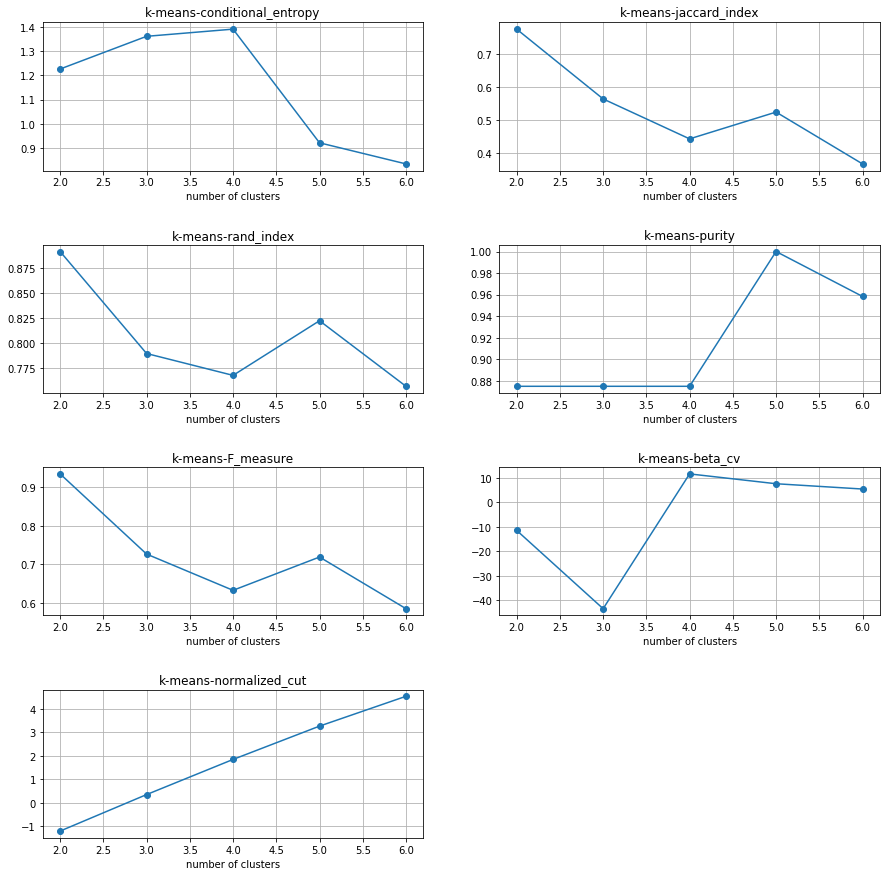

In [66]:
external_measures = {'conditional_entropy':conditional_entropy, 'jaccard_index':jaccard_index,
                     'rand_index':rand_index, 'purity':purity, 'F_measure':F_measure, 
                     'beta_cv':beta_cv_measure, 'normalized_cut':normalized_cut_measure}

internal_measures = {'beta_cv', 'normalized_cut'} 
fig = plt.figure(figsize=(15,15))
subplot_rows, subplot_cols = 4, 2
for i, (name, measure) in enumerate(external_measures.items()):
    ax = fig.add_subplot(subplot_rows,subplot_cols,i+1)
    scores = []
    k_vals = []
    for k,c in k_means_cluster_indicators.items():
        if name in internal_measures:
            scores.append(measure(X2, c))
        else:
            scores.append(measure(c, gt))
        k_vals.append(k)

    ax.plot(k_vals,scores, '-o')
    ax.set_title(f'k-means-{name}')
    ax.set_xlabel('number of clusters')
    ax.grid()
    
fig.subplots_adjust(hspace=0.5)


plt.show()
    

#### normalized cut - RBF

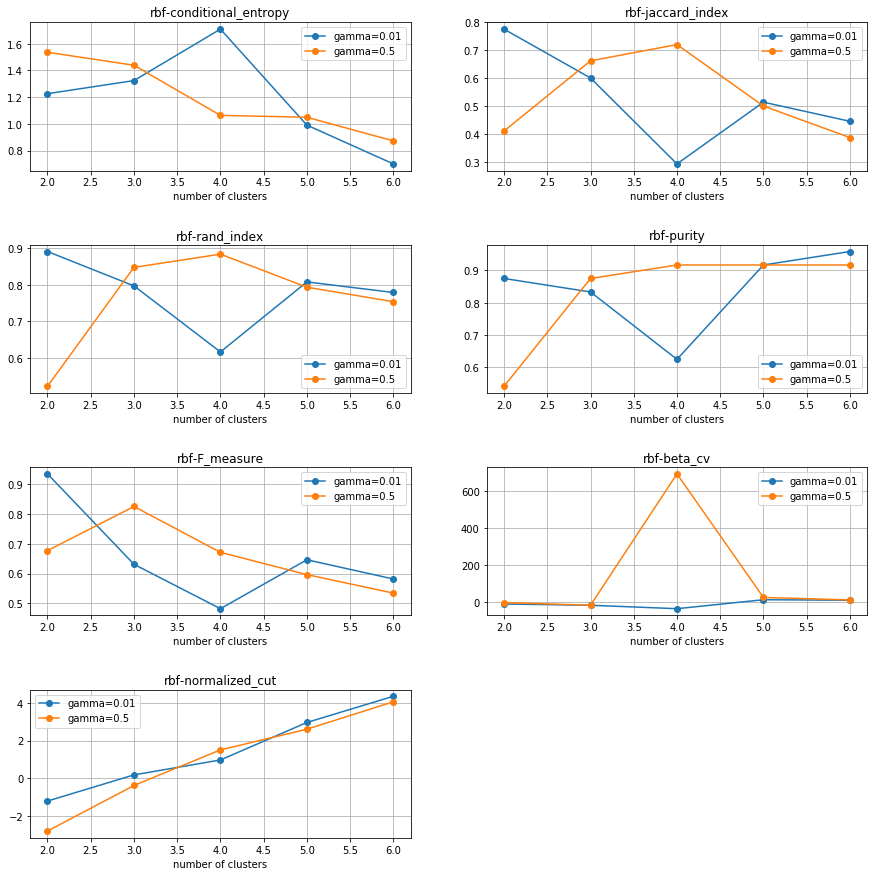

In [126]:
rbf_flattened_indicators = {0.01:[],0.5:[]}
for k,v in rbf_cluster_indicators.items():
    for gamma,arr in v.items():
        rbf_flattened_indicators[gamma].append(arr)

fig = plt.figure(figsize=(15,15))

for i, (name, measure) in enumerate(external_measures.items()):
    
    ax = fig.add_subplot(subplot_rows,subplot_cols,i+1)
    for gamma, indicators in rbf_flattened_indicators.items():
        scores = []
        for indicator in indicators:
            if name in internal_measures:
                scores.append(measure(X2, indicator))
            else:
                scores.append(measure(indicator, gt))
        ax.plot(np.arange(2,7),scores,'-o',label=f'gamma={gamma}')
    ax.set_title(f'rbf-{name}')
    ax.grid()
    ax.set_xlabel('number of clusters')
    ax.legend()
            

fig.subplots_adjust(hspace=0.5)

plt.show()

#### Normalized cut K-NN

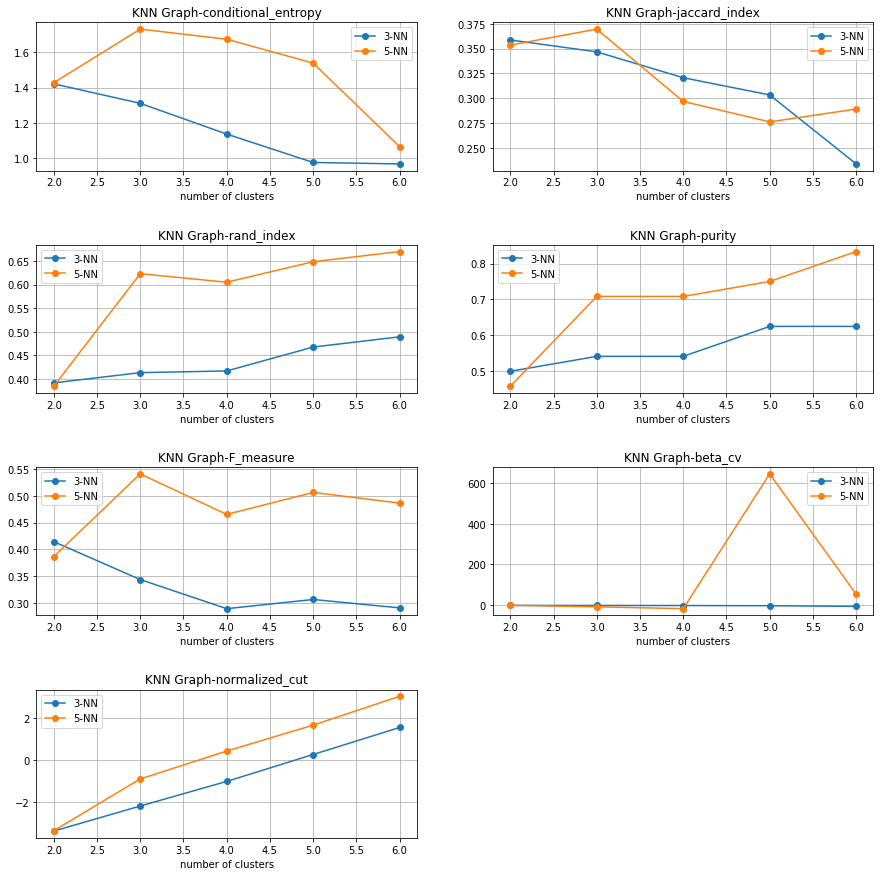

In [65]:
knn_flattened_indicators = {3:[],5:[]}
for k,v in knn_cluster_indicator.items():
    for n_neighbors,arr in v.items():
        knn_flattened_indicators[n_neighbors].append(arr)

knn_flattened_indicators
fig = plt.figure(figsize=(15,15))

for i, (name, measure) in enumerate(external_measures.items()):
    
    ax = fig.add_subplot(4,2,i+1)
    for n_neighbors, indicators in knn_flattened_indicators.items():
        scores = []
        for indicator in indicators:
            if name in internal_measures:
                scores.append(measure(X2, indicator))
            else:
                scores.append(measure(indicator, gt))
                
        ax.plot(np.arange(2,7),scores,'-o',label=f'{n_neighbors}-NN')
    ax.set_title(f'KNN Graph-{name}')
    ax.set_xlabel('number of clusters')
    ax.grid()
    ax.legend()
            
    
fig.subplots_adjust(hspace=0.5)
plt.show()

#### Maximum matching for 3 clusters

In [48]:
max_match_table = {'k means':maximum_matching(k_means_cluster_indicators[3], gt),
                   'knn 3-NN':maximum_matching(knn_cluster_indicator[3][3], gt),
                   'knn 5-NN':maximum_matching(knn_cluster_indicator[3][5], gt),
                   'rbf gamma = 0.01':maximum_matching(rbf_cluster_indicators[3][0.01], gt),
                   'rbf gamma = 0.1':maximum_matching(rbf_cluster_indicators[3][0.01],gt)}

print(max_match_table)

{'k means': 0.5833333333333334, 'knn 3-NN': 0.5, 'knn 5-NN': 0.4583333333333333, 'rbf gamma = 0.01': 0.5416666666666666, 'rbf gamma = 0.1': 0.5416666666666666}


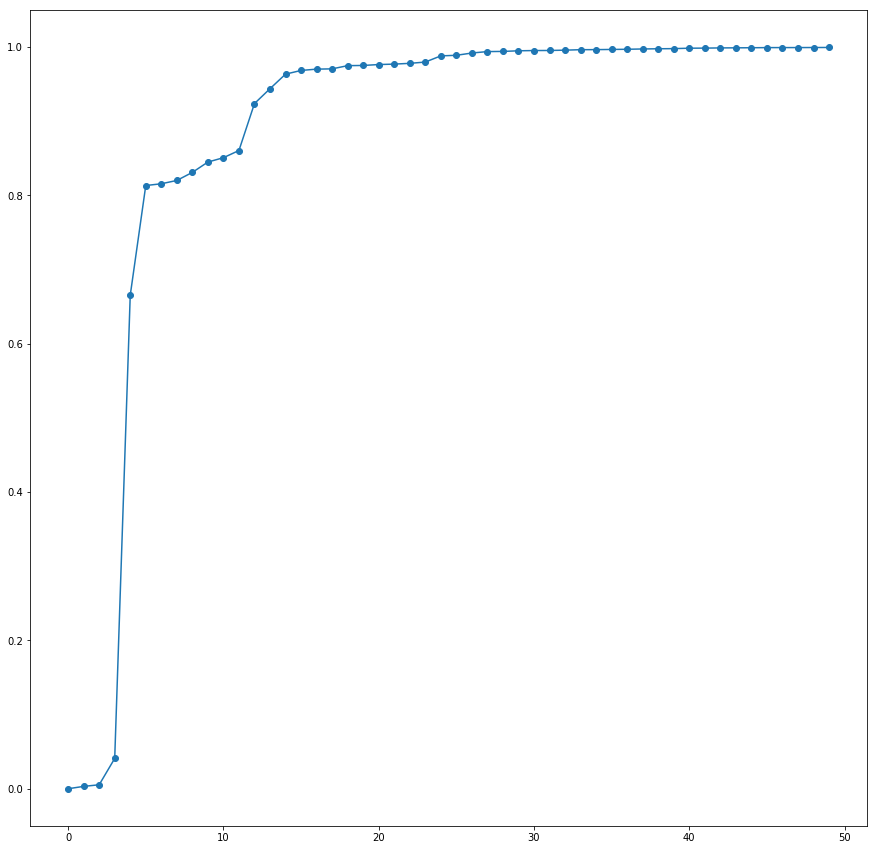

In [115]:
from sklearn import datasets
n_samples = 1000
noisy_circles = datasets.make_blobs(n_samples=n_samples, random_state=8,centers=5)

# plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1])
# plt.show()
plt.rcParams["figure.figsize"] = (15,15)
_,_,vecs,vals=spectral_clustering(affinity=rbf_kernel(noisy_circles[0], gamma=0.1),k=2,n_clusters=3)
plt.plot(vals[:50].real,'-o')
plt.show()